## Get all the imports here

In [1]:
import pandas as pd
import numpy as np
import random
from mnist import MNIST
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import contextlib
np.random.seed(27)
random.seed(27)
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from scipy.stats import binned_statistic
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from FRUFS import FRUFS
from matplotlib.pyplot import figure

## Load Data

In [2]:
# A utility variable to define the number of classes
num_classes = 10
# A utility variable that defines the number of sub-samples to pick from each class
subset_samples = 100

# MNIST library allows easy loading of MNIST data
mndata = MNIST("../data/mnist/")
X_train, Y_train = mndata.load_training()
X_test, Y_test = mndata.load_testing()

# Converting to numpy matrix
X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
X_test, Y_test = np.asarray(X_test), np.asarray(Y_test)

# Take a stratified random subset of samples from each class
inds = list()
for i in range(num_classes):
    curr_inds = np.where(Y_train==i)[0]
    inds+= list(curr_inds[np.random.randint(0, len(curr_inds), size=subset_samples)])

# Use the indices generated above to take a subset of the training data
X_train = X_train[inds]
Y_train = Y_train[inds]

# Take a stratified random subset of samples from each class
inds = list()
for i in range(num_classes):
    curr_inds = np.where(Y_test==i)[0]
    inds+= list(curr_inds[np.random.randint(0, len(curr_inds), size=subset_samples)])
    
# Use the indices generated above to take a subset of the test data
X_test = X_test[inds]
Y_test = Y_test[inds]

# Check out the data shapes
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Train Data Shape: (1000, 784)
Test Data Shape: (1000, 784)


## Grab a baseline score

In [3]:
# We are going to use the K-Means algorithm
model_kmeans = KMeans(n_clusters=num_classes, random_state=27)
model_kmeans.fit(X_train)
preds = model_kmeans.predict(X_test)

# We are going to use the NMI metric to measure the quality/performance of the clustering 
baseline_score = normalized_mutual_info_score(Y_test, preds)
print("Baseline NMI Score:", baseline_score)

Baseline NMI Score: 0.5048109059079248


## Run the unsupervised feature selection method

In [4]:
model = FRUFS(model_r=LGBMRegressor(random_state=27), k=0.42, n_jobs=-1, verbose=0, random_state=27)
X_train_transformed = model.fit_transform(X_train)
X_test_transformed = model.transform(X_test)

Progress bar: 100%|██████| 784/784 [02:36<00:00,  5.01it/s]


## Check out the performance of the selected features

In [5]:
model_kmeans = KMeans(n_clusters=num_classes, random_state=27)
model_kmeans.fit(X_train_transformed)
preds = model_kmeans.predict(X_test_transformed)
print(normalized_mutual_info_score(Y_test, preds))

0.5369955594316096


## Plot out the feature importances. The blue dashed line indicates the cut-off point you have set.

## Note: You can set K in FRUFS by inspecting the feature importance 

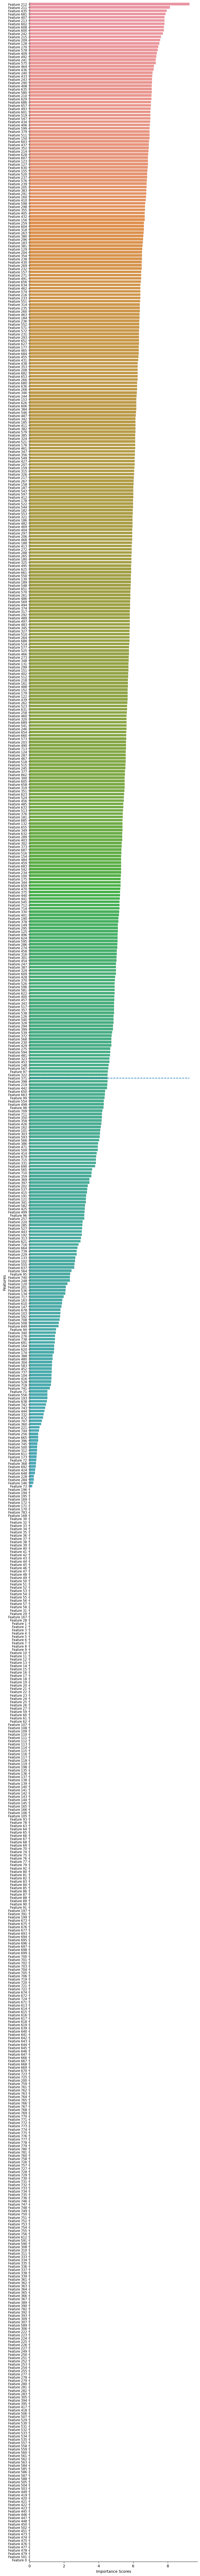

In [6]:
figure(figsize=(8, 125), dpi=100)
model.feature_importance()

## Generate a mask to inspect pixel importance using the selected features

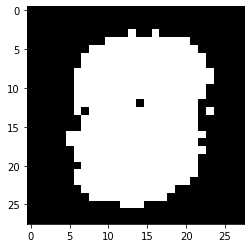

In [13]:
img_mask = np.zeros(len(model.columns_))
inds = model.columns_[:model.k]
img_mask[inds] = 1
img_mask = np.reshape(img_mask, (28, 28))
plt.imshow(img_mask, cmap='gray')